In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils import data
import torchvision.transforms as transforms
from PIL import Image

In [37]:
import json
from bunch import Bunch

def get_config_from_json(json_file):
    """
    Get the config from a json file
    :param json_file:
    :return: config(namespace) or config(dictionary)
    """
    # parse the configurations from the config json file provided

    with open(json_file, 'r') as config_file:
        config_dict = json.load(config_file)

    # convert the dictionary to a namespace using bunch lib
    config = Bunch(config_dict)

    return config, config_dict

In [38]:
def crop_args(bndbox):
    h, w, x, y = bndbox
    return (x, y, x+w, y+h)

In [39]:
def create_graph_matrices(adj, node_pad, edge_pad):
    num_nodes = adj.shape[0]
    G = np.zeros((node_pad, edge_pad), dtype=np.float32)
    H = np.zeros((node_pad, edge_pad), dtype=np.float32)
    edge_idx = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adj[i, j] == 1:
                G[i, edge_idx] = 1
                H[j, edge_idx] = 1
                edge_idx += 1
    return G, H

In [40]:
class Dataset(data.Dataset):
    def __init__(self, data_config, mode='train', dtype=torch.double):
        self.data_config = data_config
        self.mode = mode if mode in ['train', 'val'] else 'train'
        self.dtype = dtype
        filename = os.path.join(self.data_config.base_path,
                            self.data_config.graph_folder,
                            '.'.join([mode, 'txt']))
        def process_entry(entry):
            entry = entry.rstrip().split('\t')
            bndbox_s = [float(val) for val in entry[4:8]]
            bndbox_t = [float(val) for val in entry[8:12]]
            return {'id': entry[0],
                   'img_s': entry[1],
                   'img_t': entry[2],
                   'cat': entry[3],
                   'bndbox_s': bndbox_s,
                   'bndbox_t': bndbox_t}
            
        with open(filename, 'r') as f:
            self.contents = list(map(process_entry, f.readlines()))

    def __len__(self):
        return len(self.contents)

    def __getitem__(self, index):
        row = self.contents[index]
        
        # First, transform source and target image
        img_path = os.path.join(self.data_config.base_path,
                               self.data_config.img_folder)
        transform = transforms.Compose(
            [transforms.Resize((256, 256)),
             transforms.ToTensor(),
             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])
        img_source = Image.open(os.path.join(img_path, '.'.join([row['img_s'], 'jpg'])))
        img_target = Image.open(os.path.join(img_path, '.'.join([row['img_t'], 'jpg'])))
        img_source = img_source.crop(crop_args(row['bndbox_s']))
        img_target = img_target.crop(crop_args(row['bndbox_t']))
        
        img_source = transform(img_source).type(dtype=self.dtype)
        img_target = transform(img_target).type(dtype=self.dtype)

        # Load matrices from serialized numpy objects
        graph_path = os.path.join(self.data_config.base_path,
                                 self.data_config.graph_folder)
        adj_file = os.path.join(graph_path, 'adj', '.'.join([row['id'], 'npy']))
        points_file = os.path.join(graph_path, 'points', '.'.join([row['id'], 'npy']))
        
        adj = np.load(adj_file)
        points = np.load(points_file)
        adj_s, adj_t = adj[0], adj[1]
        points_s, points_t = points[0], points[1]
        
        G_s, H_s = create_graph_matrices(adj_s,
                                         node_pad=self.data_config.node_pad,
                                         edge_pad=self.data_config.edge_pad)
        G_t, H_t = create_graph_matrices(adj_t,
                                         node_pad=self.data_config.node_pad,
                                         edge_pad=self.data_config.edge_pad)
        
        G_s = torch.from_numpy(G_s).to_sparse()
        H_s = torch.from_numpy(H_s).to_sparse()
        G_t = torch.from_numpy(G_t).to_sparse()
        H_t = torch.from_numpy(H_t).to_sparse()
        
        num_true_nodes = points_s.shape[0]
        pad = self.data_config.node_pad - num_true_nodes
        pad_zeros = np.zeros((pad, 2), dtype=points.dtype)
        padded_points_s = np.concatenate((points_s, pad_zeros))
        padded_points_t = np.concatenate((points_t, pad_zeros))
        padded_points_s = torch.from_numpy(padded_points_s)
        padded_points_t = torch.from_numpy(padded_points_t)
        
        # We use mask to keep track of the true (i.e. not padded) nodes
        mask = torch.zeros((self.data_config.node_pad, 1), dtype=torch.long)
        mask[:num_true_nodes] = 1
        
        return img_source, img_target, G_s, G_t, H_s, H_t, padded_points_s, padded_points_t, mask

In [41]:
my_conf, _ = get_config_from_json(os.path.join('../configs', 'data_config.json'))

In [42]:
training_data = Dataset(my_conf, mode='train')

In [43]:
print(training_data.data_config.base_path)
print(training_data.data_config.img_folder)
print(training_data.data_config.annotation_folder)
print(training_data.data_config.graph_folder)

C:/VOC/VOCdevkit/VOC2011
JPEGImages
ANNOTATIONS
graph


In [44]:
print(len(training_data.contents))

7991


In [45]:
res = training_data.__getitem__(0)
for res_tensor in res:
    print(res_tensor.shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([20, 400])
torch.Size([20, 400])
torch.Size([20, 400])
torch.Size([20, 400])
torch.Size([20, 2])
torch.Size([20, 2])
torch.Size([20, 1])


In [46]:
def renormalized_tensor(img_tensor, img_mean=[0.485, 0.456, 0.406], img_std=[0.229, 0.224, 0.225]):
    img = np.moveaxis(img_tensor.numpy(), [0, 1, 2], [2, 0, 1])
    img_mean = np.array(img_mean)
    img_std = np.array(img_std)
    img = img_std.reshape(1, 1, -1) * img + img_mean.reshape(1, 1, -1)
    img *= 255
    return img.astype(int)

In [47]:
dl = data.DataLoader(
        training_data,
        batch_size=8, shuffle=False
    )

In [48]:
next_tuple = next(iter(dl))
for tmp in next_tuple:
    print(tmp.shape)

torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])
torch.Size([8, 20, 400])
torch.Size([8, 20, 400])
torch.Size([8, 20, 400])
torch.Size([8, 20, 400])
torch.Size([8, 20, 2])
torch.Size([8, 20, 2])
torch.Size([8, 20, 1])


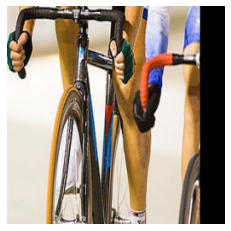

In [49]:
img_x = renormalized_tensor(next_tuple[0][3])
plt.imshow(img_x)
plt.axis('off')
plt.show()

In [34]:
print(next_tuple[-1][0])

tensor([[1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


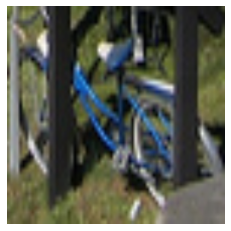

In [35]:
img_y = renormalized_tensor(next_tuple[1][3])
plt.imshow(img_y)
plt.axis('off')
plt.show()